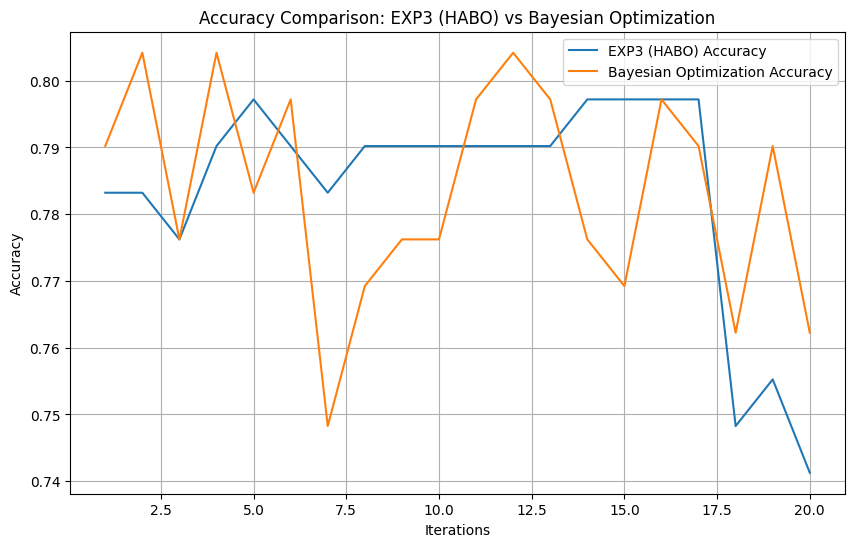

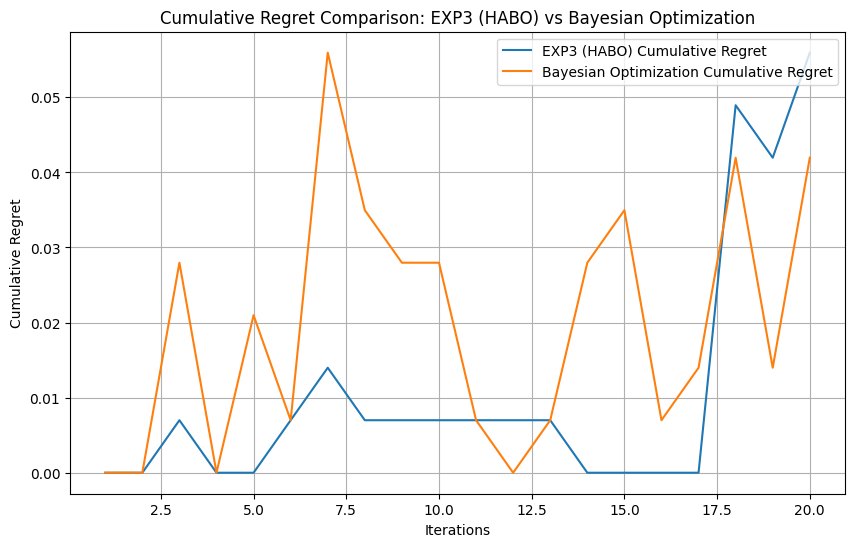

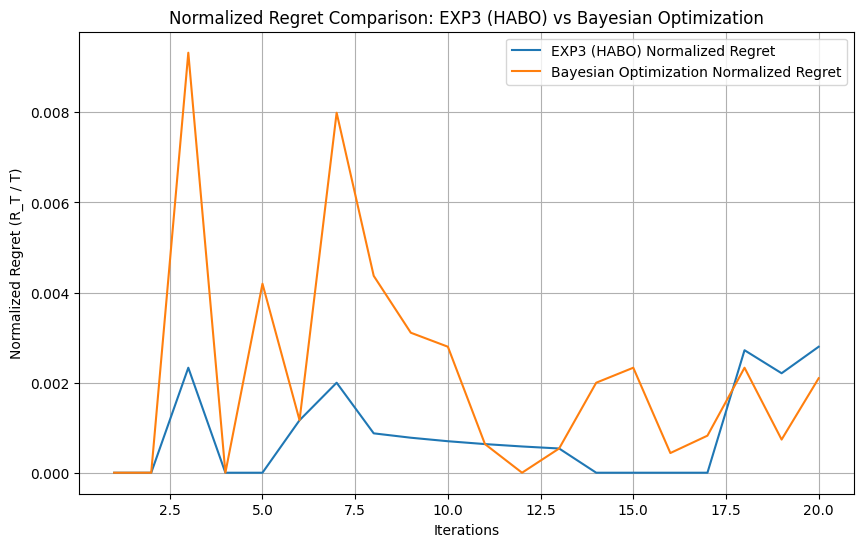

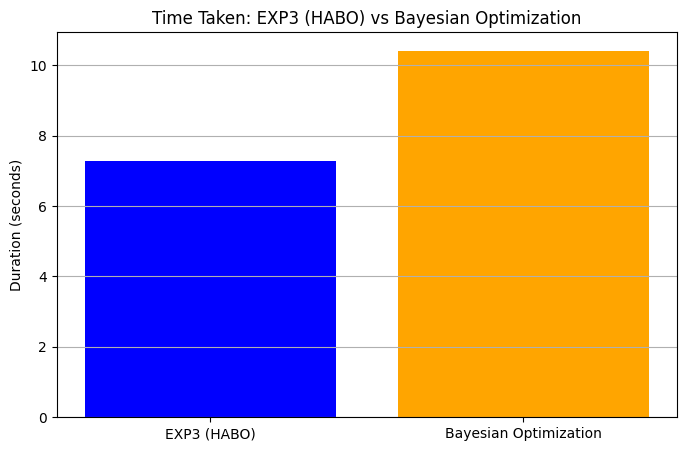

In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

from time import time

from skopt import gp_minimize

from skopt.space import Integer, Categorical

from skopt.utils import use_named_args



# Define the EXP3 algorithm class

class EXP3:

    def __init__(self, n_arms, gamma=0.1):

        self.n_arms = n_arms

        self.gamma = gamma

        self.weights = np.ones(n_arms)

    

    def select_arm(self):

        total_weight = np.sum(self.weights)

        probabilities = (

            (1 - self.gamma) * (self.weights / total_weight) +

            (self.gamma / self.n_arms)

        )

        arm = np.random.choice(self.n_arms, p=probabilities)

        return arm, probabilities

    

    def update(self, chosen_arm, reward, probabilities):

        x = reward / probabilities[chosen_arm]

        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)





# Load the Titanic dataset and preprocess

data = pd.read_csv('train.csv')

data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

data = data.dropna()



label_encoders = {}

for column in ['Sex', 'Embarked']:

    le = LabelEncoder()

    data[column] = le.fit_transform(data[column])

    label_encoders[column] = le



X = data.drop('Survived', axis=1)

y = data['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(

    X, y, test_size=0.2, random_state=42

)



# EXP3 setup

hyperparameter_values = {

    'n_estimators': list(range(50, 301, 5)),

    'max_depth': [None] + list(range(5, 100, 5)),

    'min_samples_split': list(range(2, 50, 2)),

    'max_features': ['sqrt', 'log2', None]

}



current_params = {

    'n_estimators': 50,

    'max_depth': None,

    'min_samples_split': 2,

    'max_features': 'sqrt'

}



bandits = {hp: {'algorithm': EXP3(len(hyperparameter_values[hp]))} for hp in hyperparameter_values}

hyperparameters = list(hyperparameter_values.keys())

hyperparameter_bandit = EXP3(len(hyperparameters))



best_possible_reward = 0

best_accuracy_exp3 = 0

cumulative_regret_exp3 = []

accuracy_exp3 = []

exp3_start = time()



# EXP3 hyperparameter tuning loop

for i in range(20):

    hp_arm_index, hp_probabilities = hyperparameter_bandit.select_arm()

    hp_to_adjust = hyperparameters[hp_arm_index]

    algorithm = bandits[hp_to_adjust]['algorithm']

    arm_index, probabilities = algorithm.select_arm()

    hp_value = hyperparameter_values[hp_to_adjust][arm_index]

    

    previous_value = current_params[hp_to_adjust]

    current_params[hp_to_adjust] = hp_value



    model = RandomForestClassifier(

        n_estimators=current_params['n_estimators'],

        max_depth=current_params['max_depth'],

        min_samples_split=current_params['min_samples_split'],

        max_features=current_params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    reward = accuracy



    algorithm.update(arm_index, reward, probabilities)

    hyperparameter_bandit.update(hp_arm_index, reward, hp_probabilities)



    best_possible_reward = max(best_possible_reward, reward)

    cumulative_regret_exp3.append(best_possible_reward - reward)

    accuracy_exp3.append(accuracy)

    if accuracy > best_accuracy_exp3:

        best_accuracy_exp3 = accuracy

        best_params_exp3 = current_params.copy()



exp3_end = time()

exp3_duration = exp3_end - exp3_start



# Bayesian Optimization setup

space = [

    Integer(50, 300, name='n_estimators'),

    Integer(5, 100, name='max_depth'),

    Integer(2, 50, name='min_samples_split'),

    Categorical(['sqrt', 'log2', None], name='max_features')

]



@use_named_args(space)

def objective(**params):

    model = RandomForestClassifier(

        n_estimators=params['n_estimators'],

        max_depth=params['max_depth'],

        min_samples_split=params['min_samples_split'],

        max_features=params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    return -accuracy



bayesian_start = time()

result = gp_minimize(objective, space, n_calls=20, random_state=42)

bayesian_end = time()

bayesian_duration = bayesian_end - bayesian_start



best_params_bo = {

    'n_estimators': result.x[0],

    'max_depth': result.x[1],

    'min_samples_split': result.x[2],

    'max_features': result.x[3]

}



final_model_bo = RandomForestClassifier(

    n_estimators=best_params_bo['n_estimators'],

    max_depth=best_params_bo['max_depth'],

    min_samples_split=best_params_bo['min_samples_split'],

    max_features=best_params_bo['max_features'],

    random_state=42

)

final_model_bo.fit(X_train, y_train)

final_y_pred_bo = final_model_bo.predict(X_valid)

final_accuracy_bo = accuracy_score(y_valid, final_y_pred_bo)



cumulative_regret_bo = []

accuracy_bo = []

best_possible_reward_bo = 0

for i, func_val in enumerate(result.func_vals):

    reward = -func_val

    best_possible_reward_bo = max(best_possible_reward_bo, reward)

    cumulative_regret_bo.append(best_possible_reward_bo - reward)

    accuracy_bo.append(reward)



# Plot accuracy comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), accuracy_exp3, label="EXP3 (HABO) Accuracy")

plt.plot(range(1, 21), accuracy_bo, label="Bayesian Optimization Accuracy")

plt.xlabel("Iterations")

plt.ylabel("Accuracy")

plt.title("Accuracy Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot cumulative regret comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), cumulative_regret_exp3, label="EXP3 (HABO) Cumulative Regret")

plt.plot(range(1, 21), cumulative_regret_bo, label="Bayesian Optimization Cumulative Regret")

plt.xlabel("Iterations")

plt.ylabel("Cumulative Regret")

plt.title("Cumulative Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot normalized regret comparison

normalized_regret_exp3 = [reg / t for reg, t in zip(cumulative_regret_exp3, range(1, 21))]

normalized_regret_bo = [reg / t for reg, t in zip(cumulative_regret_bo, range(1, 21))]



plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), normalized_regret_exp3, label="EXP3 (HABO) Normalized Regret")

plt.plot(range(1, 21), normalized_regret_bo, label="Bayesian Optimization Normalized Regret")

plt.xlabel("Iterations")

plt.ylabel("Normalized Regret (R_T / T)")

plt.title("Normalized Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Time comparison bar chart

plt.figure(figsize=(8, 5))

plt.bar(["EXP3 (HABO)", "Bayesian Optimization"], [exp3_duration, bayesian_duration], color=['blue', 'orange'])

plt.ylabel("Duration (seconds)")

plt.title("Time Taken: EXP3 (HABO) vs Bayesian Optimization")

plt.grid(axis='y')

plt.show()

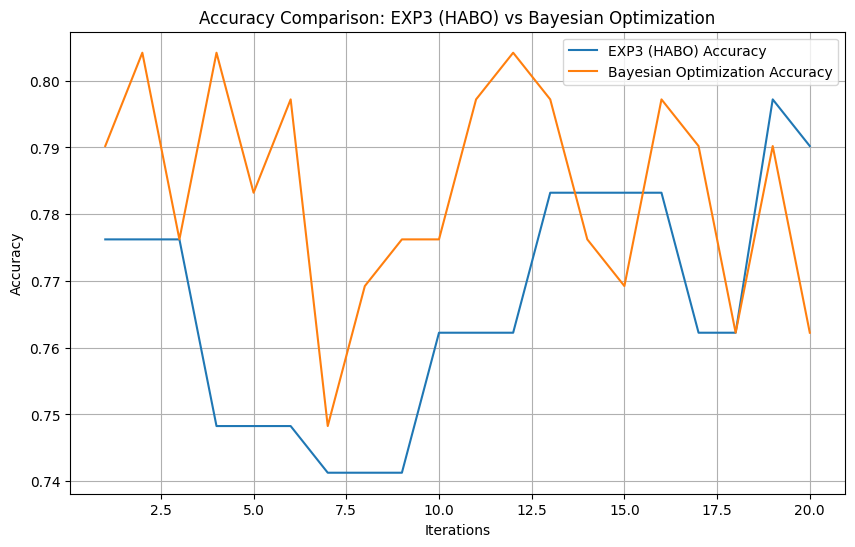

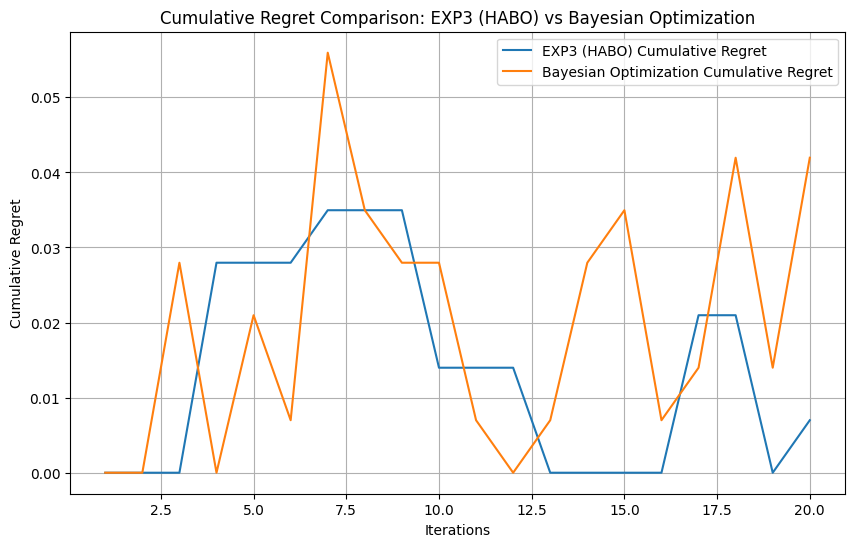

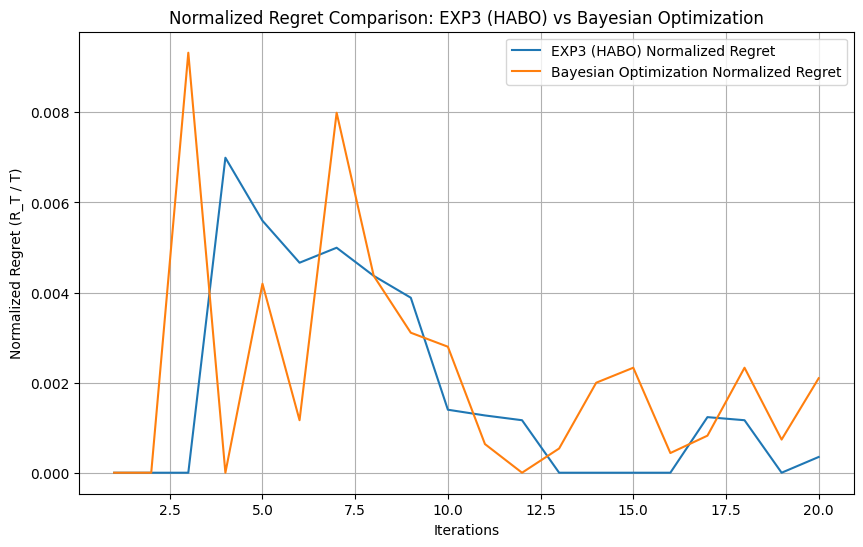

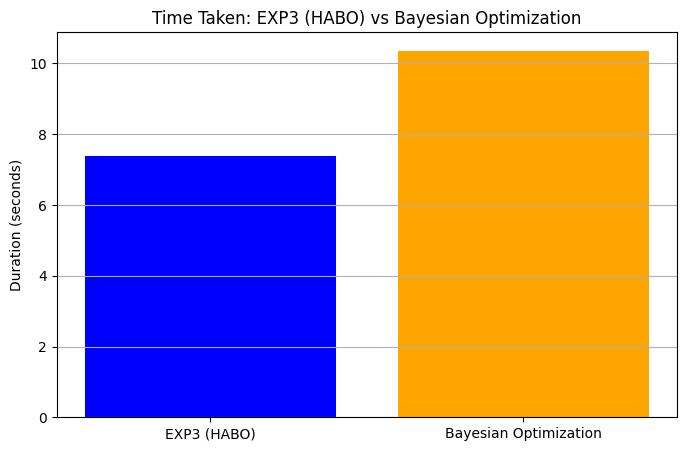

In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

from time import time

from skopt import gp_minimize

from skopt.space import Integer, Categorical

from skopt.utils import use_named_args



# Define the EXP3 algorithm class

class EXP3:

    def __init__(self, n_arms, gamma=0.1):

        self.n_arms = n_arms

        self.gamma = gamma

        self.weights = np.ones(n_arms)

    

    def select_arm(self):

        total_weight = np.sum(self.weights)

        probabilities = (

            (1 - self.gamma) * (self.weights / total_weight) +

            (self.gamma / self.n_arms)

        )

        arm = np.random.choice(self.n_arms, p=probabilities)

        return arm, probabilities

    

    def update(self, chosen_arm, reward, probabilities):

        x = reward / probabilities[chosen_arm]

        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)





# Load the Titanic dataset and preprocess

data = pd.read_csv('train.csv')

data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

data = data.dropna()



label_encoders = {}

for column in ['Sex', 'Embarked']:

    le = LabelEncoder()

    data[column] = le.fit_transform(data[column])

    label_encoders[column] = le



X = data.drop('Survived', axis=1)

y = data['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(

    X, y, test_size=0.2, random_state=42

)



# EXP3 setup

hyperparameter_values = {

    'n_estimators': list(range(50, 301, 5)),

    'max_depth': [None] + list(range(5, 100, 5)),

    'min_samples_split': list(range(2, 50, 2)),

    'max_features': ['sqrt', 'log2', None]

}



current_params = {

    'n_estimators': 50,

    'max_depth': None,

    'min_samples_split': 2,

    'max_features': 'sqrt'

}



bandits = {hp: {'algorithm': EXP3(len(hyperparameter_values[hp]))} for hp in hyperparameter_values}

hyperparameters = list(hyperparameter_values.keys())

hyperparameter_bandit = EXP3(len(hyperparameters))



best_possible_reward = 0

best_accuracy_exp3 = 0

cumulative_regret_exp3 = []

accuracy_exp3 = []

exp3_start = time()



# EXP3 hyperparameter tuning loop

for i in range(20):

    hp_arm_index, hp_probabilities = hyperparameter_bandit.select_arm()

    hp_to_adjust = hyperparameters[hp_arm_index]

    algorithm = bandits[hp_to_adjust]['algorithm']

    arm_index, probabilities = algorithm.select_arm()

    hp_value = hyperparameter_values[hp_to_adjust][arm_index]

    

    previous_value = current_params[hp_to_adjust]

    current_params[hp_to_adjust] = hp_value



    model = RandomForestClassifier(

        n_estimators=current_params['n_estimators'],

        max_depth=current_params['max_depth'],

        min_samples_split=current_params['min_samples_split'],

        max_features=current_params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    reward = accuracy



    algorithm.update(arm_index, reward, probabilities)

    hyperparameter_bandit.update(hp_arm_index, reward, hp_probabilities)



    best_possible_reward = max(best_possible_reward, reward)

    cumulative_regret_exp3.append(best_possible_reward - reward)

    accuracy_exp3.append(accuracy)

    if accuracy > best_accuracy_exp3:

        best_accuracy_exp3 = accuracy

        best_params_exp3 = current_params.copy()



exp3_end = time()

exp3_duration = exp3_end - exp3_start



# Bayesian Optimization setup

space = [

    Integer(50, 300, name='n_estimators'),

    Integer(5, 100, name='max_depth'),

    Integer(2, 50, name='min_samples_split'),

    Categorical(['sqrt', 'log2', None], name='max_features')

]



@use_named_args(space)

def objective(**params):

    model = RandomForestClassifier(

        n_estimators=params['n_estimators'],

        max_depth=params['max_depth'],

        min_samples_split=params['min_samples_split'],

        max_features=params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    return -accuracy



bayesian_start = time()

result = gp_minimize(objective, space, n_calls=20, random_state=42)

bayesian_end = time()

bayesian_duration = bayesian_end - bayesian_start



best_params_bo = {

    'n_estimators': result.x[0],

    'max_depth': result.x[1],

    'min_samples_split': result.x[2],

    'max_features': result.x[3]

}



final_model_bo = RandomForestClassifier(

    n_estimators=best_params_bo['n_estimators'],

    max_depth=best_params_bo['max_depth'],

    min_samples_split=best_params_bo['min_samples_split'],

    max_features=best_params_bo['max_features'],

    random_state=42

)

final_model_bo.fit(X_train, y_train)

final_y_pred_bo = final_model_bo.predict(X_valid)

final_accuracy_bo = accuracy_score(y_valid, final_y_pred_bo)



cumulative_regret_bo = []

accuracy_bo = []

best_possible_reward_bo = 0

for i, func_val in enumerate(result.func_vals):

    reward = -func_val

    best_possible_reward_bo = max(best_possible_reward_bo, reward)

    cumulative_regret_bo.append(best_possible_reward_bo - reward)

    accuracy_bo.append(reward)



# Plot accuracy comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), accuracy_exp3, label="EXP3 (HABO) Accuracy")

plt.plot(range(1, 21), accuracy_bo, label="Bayesian Optimization Accuracy")

plt.xlabel("Iterations")

plt.ylabel("Accuracy")

plt.title("Accuracy Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot cumulative regret comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), cumulative_regret_exp3, label="EXP3 (HABO) Cumulative Regret")

plt.plot(range(1, 21), cumulative_regret_bo, label="Bayesian Optimization Cumulative Regret")

plt.xlabel("Iterations")

plt.ylabel("Cumulative Regret")

plt.title("Cumulative Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot normalized regret comparison

normalized_regret_exp3 = [reg / t for reg, t in zip(cumulative_regret_exp3, range(1, 21))]

normalized_regret_bo = [reg / t for reg, t in zip(cumulative_regret_bo, range(1, 21))]



plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), normalized_regret_exp3, label="EXP3 (HABO) Normalized Regret")

plt.plot(range(1, 21), normalized_regret_bo, label="Bayesian Optimization Normalized Regret")

plt.xlabel("Iterations")

plt.ylabel("Normalized Regret (R_T / T)")

plt.title("Normalized Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Time comparison bar chart

plt.figure(figsize=(8, 5))

plt.bar(["EXP3 (HABO)", "Bayesian Optimization"], [exp3_duration, bayesian_duration], color=['blue', 'orange'])

plt.ylabel("Duration (seconds)")

plt.title("Time Taken: EXP3 (HABO) vs Bayesian Optimization")

plt.grid(axis='y')

plt.show()

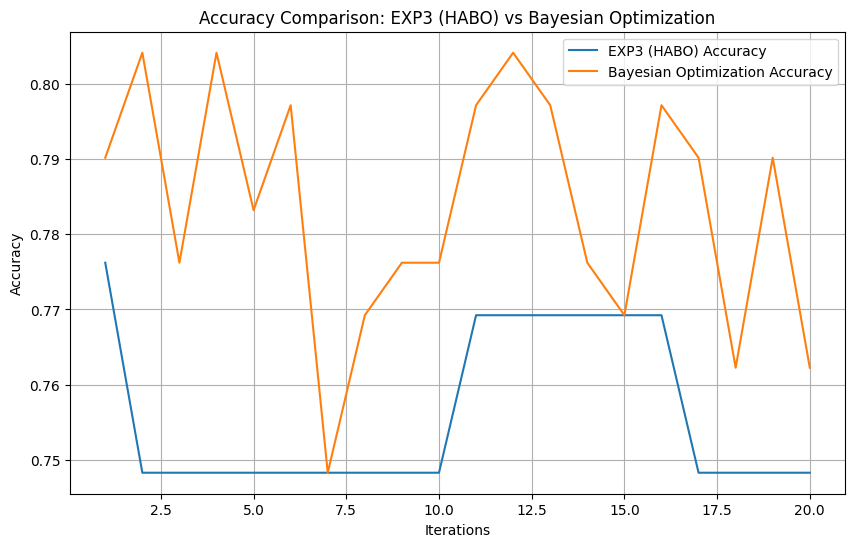

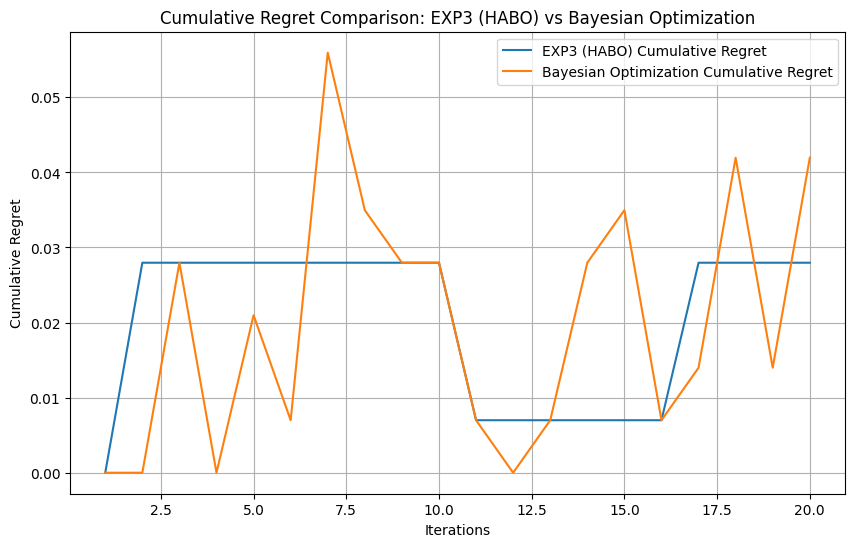

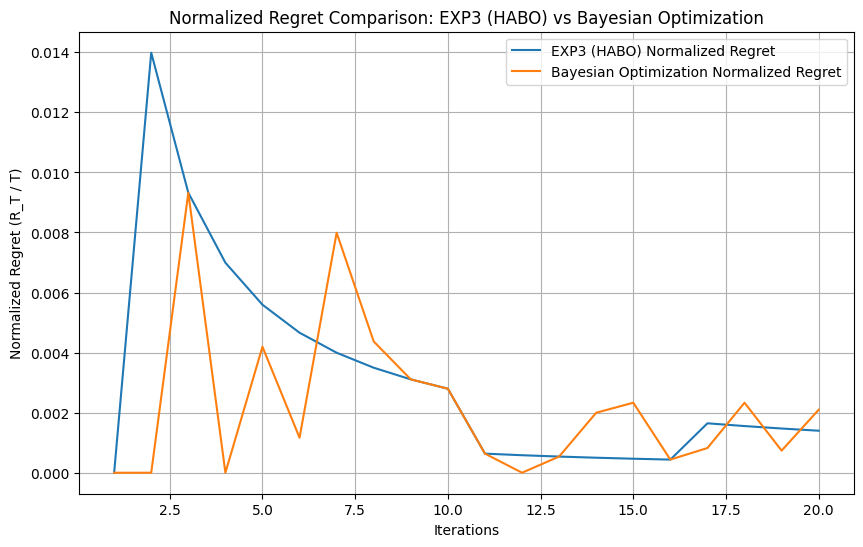

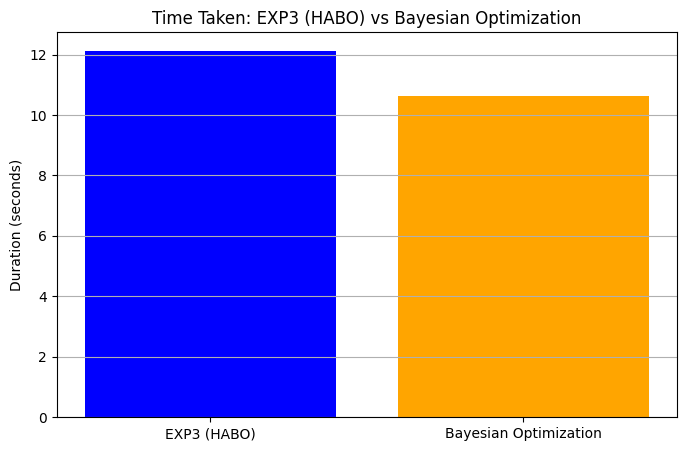

In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

from time import time

from skopt import gp_minimize

from skopt.space import Integer, Categorical

from skopt.utils import use_named_args



# Define the EXP3 algorithm class

class EXP3:

    def __init__(self, n_arms, gamma=0.1):

        self.n_arms = n_arms

        self.gamma = gamma

        self.weights = np.ones(n_arms)

    

    def select_arm(self):

        total_weight = np.sum(self.weights)

        probabilities = (

            (1 - self.gamma) * (self.weights / total_weight) +

            (self.gamma / self.n_arms)

        )

        arm = np.random.choice(self.n_arms, p=probabilities)

        return arm, probabilities

    

    def update(self, chosen_arm, reward, probabilities):

        x = reward / probabilities[chosen_arm]

        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)





# Load the Titanic dataset and preprocess

data = pd.read_csv('train.csv')

data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

data = data.dropna()



label_encoders = {}

for column in ['Sex', 'Embarked']:

    le = LabelEncoder()

    data[column] = le.fit_transform(data[column])

    label_encoders[column] = le



X = data.drop('Survived', axis=1)

y = data['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(

    X, y, test_size=0.2, random_state=42

)



# EXP3 setup

hyperparameter_values = {

    'n_estimators': list(range(50, 301, 5)),

    'max_depth': [None] + list(range(5, 100, 5)),

    'min_samples_split': list(range(2, 50, 2)),

    'max_features': ['sqrt', 'log2', None]

}



current_params = {

    'n_estimators': 50,

    'max_depth': None,

    'min_samples_split': 2,

    'max_features': 'sqrt'

}



bandits = {hp: {'algorithm': EXP3(len(hyperparameter_values[hp]))} for hp in hyperparameter_values}

hyperparameters = list(hyperparameter_values.keys())

hyperparameter_bandit = EXP3(len(hyperparameters))



best_possible_reward = 0

best_accuracy_exp3 = 0

cumulative_regret_exp3 = []

accuracy_exp3 = []

exp3_start = time()



# EXP3 hyperparameter tuning loop

for i in range(20):

    hp_arm_index, hp_probabilities = hyperparameter_bandit.select_arm()

    hp_to_adjust = hyperparameters[hp_arm_index]

    algorithm = bandits[hp_to_adjust]['algorithm']

    arm_index, probabilities = algorithm.select_arm()

    hp_value = hyperparameter_values[hp_to_adjust][arm_index]

    

    previous_value = current_params[hp_to_adjust]

    current_params[hp_to_adjust] = hp_value



    model = RandomForestClassifier(

        n_estimators=current_params['n_estimators'],

        max_depth=current_params['max_depth'],

        min_samples_split=current_params['min_samples_split'],

        max_features=current_params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    reward = accuracy



    algorithm.update(arm_index, reward, probabilities)

    hyperparameter_bandit.update(hp_arm_index, reward, hp_probabilities)



    best_possible_reward = max(best_possible_reward, reward)

    cumulative_regret_exp3.append(best_possible_reward - reward)

    accuracy_exp3.append(accuracy)

    if accuracy > best_accuracy_exp3:

        best_accuracy_exp3 = accuracy

        best_params_exp3 = current_params.copy()



exp3_end = time()

exp3_duration = exp3_end - exp3_start



# Bayesian Optimization setup

space = [

    Integer(50, 300, name='n_estimators'),

    Integer(5, 100, name='max_depth'),

    Integer(2, 50, name='min_samples_split'),

    Categorical(['sqrt', 'log2', None], name='max_features')

]



@use_named_args(space)

def objective(**params):

    model = RandomForestClassifier(

        n_estimators=params['n_estimators'],

        max_depth=params['max_depth'],

        min_samples_split=params['min_samples_split'],

        max_features=params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    return -accuracy



bayesian_start = time()

result = gp_minimize(objective, space, n_calls=20, random_state=42)

bayesian_end = time()

bayesian_duration = bayesian_end - bayesian_start



best_params_bo = {

    'n_estimators': result.x[0],

    'max_depth': result.x[1],

    'min_samples_split': result.x[2],

    'max_features': result.x[3]

}



final_model_bo = RandomForestClassifier(

    n_estimators=best_params_bo['n_estimators'],

    max_depth=best_params_bo['max_depth'],

    min_samples_split=best_params_bo['min_samples_split'],

    max_features=best_params_bo['max_features'],

    random_state=42

)

final_model_bo.fit(X_train, y_train)

final_y_pred_bo = final_model_bo.predict(X_valid)

final_accuracy_bo = accuracy_score(y_valid, final_y_pred_bo)



cumulative_regret_bo = []

accuracy_bo = []

best_possible_reward_bo = 0

for i, func_val in enumerate(result.func_vals):

    reward = -func_val

    best_possible_reward_bo = max(best_possible_reward_bo, reward)

    cumulative_regret_bo.append(best_possible_reward_bo - reward)

    accuracy_bo.append(reward)



# Plot accuracy comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), accuracy_exp3, label="EXP3 (HABO) Accuracy")

plt.plot(range(1, 21), accuracy_bo, label="Bayesian Optimization Accuracy")

plt.xlabel("Iterations")

plt.ylabel("Accuracy")

plt.title("Accuracy Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot cumulative regret comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), cumulative_regret_exp3, label="EXP3 (HABO) Cumulative Regret")

plt.plot(range(1, 21), cumulative_regret_bo, label="Bayesian Optimization Cumulative Regret")

plt.xlabel("Iterations")

plt.ylabel("Cumulative Regret")

plt.title("Cumulative Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot normalized regret comparison

normalized_regret_exp3 = [reg / t for reg, t in zip(cumulative_regret_exp3, range(1, 21))]

normalized_regret_bo = [reg / t for reg, t in zip(cumulative_regret_bo, range(1, 21))]



plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), normalized_regret_exp3, label="EXP3 (HABO) Normalized Regret")

plt.plot(range(1, 21), normalized_regret_bo, label="Bayesian Optimization Normalized Regret")

plt.xlabel("Iterations")

plt.ylabel("Normalized Regret (R_T / T)")

plt.title("Normalized Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Time comparison bar chart

plt.figure(figsize=(8, 5))

plt.bar(["EXP3 (HABO)", "Bayesian Optimization"], [exp3_duration, bayesian_duration], color=['blue', 'orange'])

plt.ylabel("Duration (seconds)")

plt.title("Time Taken: EXP3 (HABO) vs Bayesian Optimization")

plt.grid(axis='y')

plt.show()

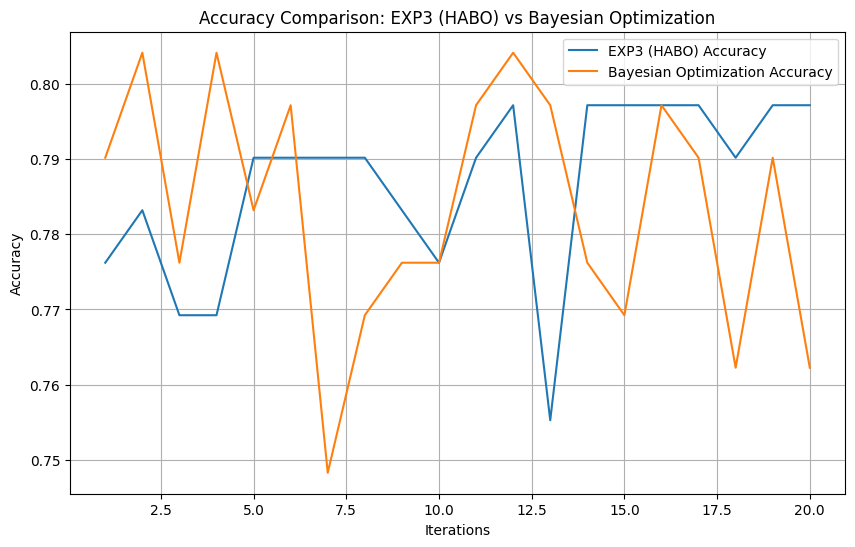

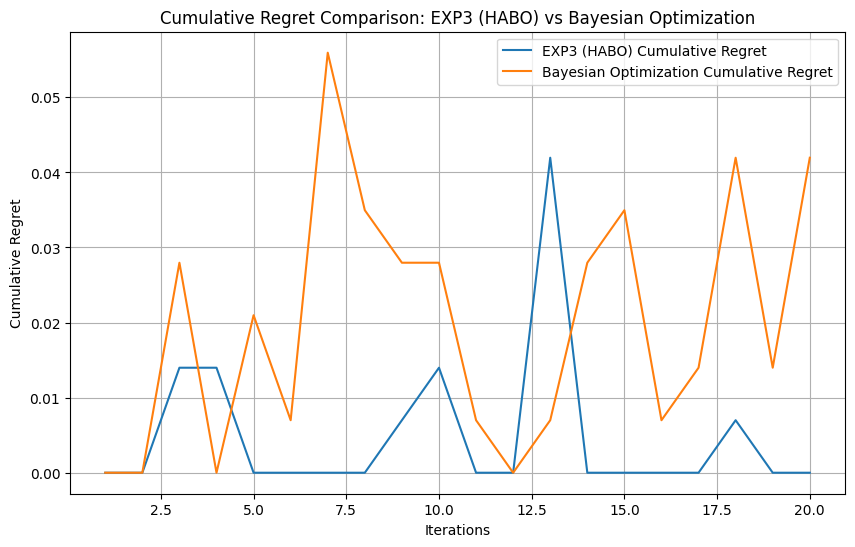

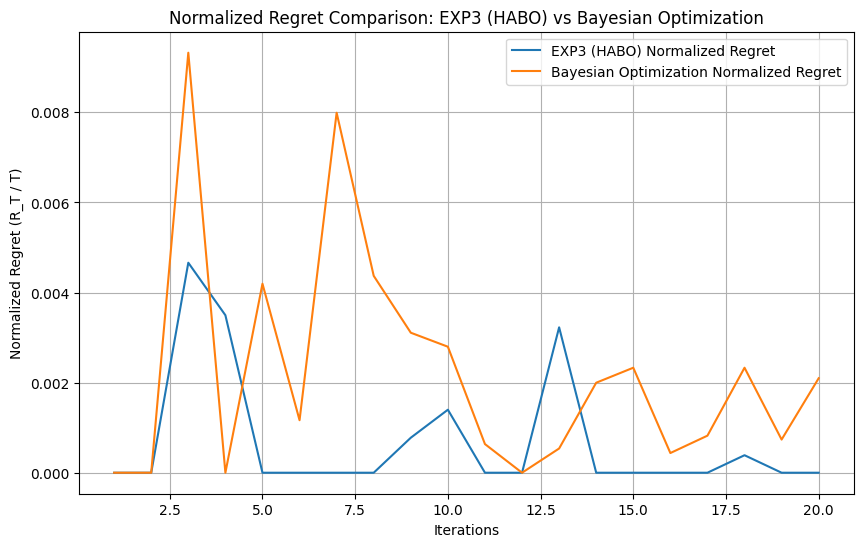

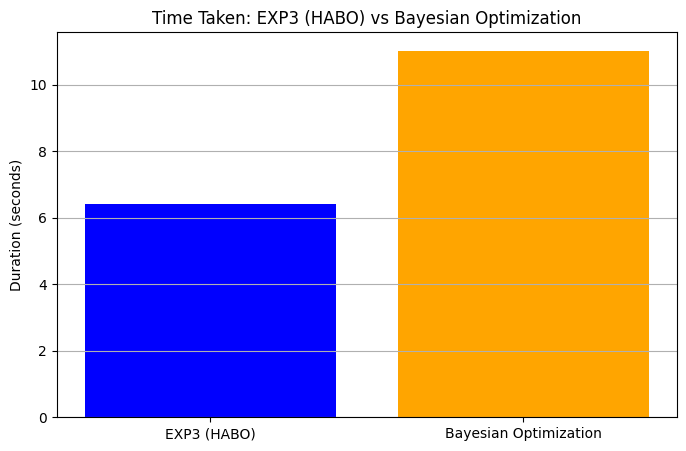

In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

from time import time

from skopt import gp_minimize

from skopt.space import Integer, Categorical

from skopt.utils import use_named_args



# Define the EXP3 algorithm class

class EXP3:

    def __init__(self, n_arms, gamma=0.1):

        self.n_arms = n_arms

        self.gamma = gamma

        self.weights = np.ones(n_arms)

    

    def select_arm(self):

        total_weight = np.sum(self.weights)

        probabilities = (

            (1 - self.gamma) * (self.weights / total_weight) +

            (self.gamma / self.n_arms)

        )

        arm = np.random.choice(self.n_arms, p=probabilities)

        return arm, probabilities

    

    def update(self, chosen_arm, reward, probabilities):

        x = reward / probabilities[chosen_arm]

        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)





# Load the Titanic dataset and preprocess

data = pd.read_csv('train.csv')

data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

data = data.dropna()



label_encoders = {}

for column in ['Sex', 'Embarked']:

    le = LabelEncoder()

    data[column] = le.fit_transform(data[column])

    label_encoders[column] = le



X = data.drop('Survived', axis=1)

y = data['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(

    X, y, test_size=0.2, random_state=42

)



# EXP3 setup

hyperparameter_values = {

    'n_estimators': list(range(50, 301, 5)),

    'max_depth': [None] + list(range(5, 100, 5)),

    'min_samples_split': list(range(2, 50, 2)),

    'max_features': ['sqrt', 'log2', None]

}



current_params = {

    'n_estimators': 50,

    'max_depth': None,

    'min_samples_split': 2,

    'max_features': 'sqrt'

}



bandits = {hp: {'algorithm': EXP3(len(hyperparameter_values[hp]))} for hp in hyperparameter_values}

hyperparameters = list(hyperparameter_values.keys())

hyperparameter_bandit = EXP3(len(hyperparameters))



best_possible_reward = 0

best_accuracy_exp3 = 0

cumulative_regret_exp3 = []

accuracy_exp3 = []

exp3_start = time()



# EXP3 hyperparameter tuning loop

for i in range(20):

    hp_arm_index, hp_probabilities = hyperparameter_bandit.select_arm()

    hp_to_adjust = hyperparameters[hp_arm_index]

    algorithm = bandits[hp_to_adjust]['algorithm']

    arm_index, probabilities = algorithm.select_arm()

    hp_value = hyperparameter_values[hp_to_adjust][arm_index]

    

    previous_value = current_params[hp_to_adjust]

    current_params[hp_to_adjust] = hp_value



    model = RandomForestClassifier(

        n_estimators=current_params['n_estimators'],

        max_depth=current_params['max_depth'],

        min_samples_split=current_params['min_samples_split'],

        max_features=current_params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    reward = accuracy



    algorithm.update(arm_index, reward, probabilities)

    hyperparameter_bandit.update(hp_arm_index, reward, hp_probabilities)



    best_possible_reward = max(best_possible_reward, reward)

    cumulative_regret_exp3.append(best_possible_reward - reward)

    accuracy_exp3.append(accuracy)

    if accuracy > best_accuracy_exp3:

        best_accuracy_exp3 = accuracy

        best_params_exp3 = current_params.copy()



exp3_end = time()

exp3_duration = exp3_end - exp3_start



# Bayesian Optimization setup

space = [

    Integer(50, 300, name='n_estimators'),

    Integer(5, 100, name='max_depth'),

    Integer(2, 50, name='min_samples_split'),

    Categorical(['sqrt', 'log2', None], name='max_features')

]



@use_named_args(space)

def objective(**params):

    model = RandomForestClassifier(

        n_estimators=params['n_estimators'],

        max_depth=params['max_depth'],

        min_samples_split=params['min_samples_split'],

        max_features=params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    return -accuracy



bayesian_start = time()

result = gp_minimize(objective, space, n_calls=20, random_state=42)

bayesian_end = time()

bayesian_duration = bayesian_end - bayesian_start



best_params_bo = {

    'n_estimators': result.x[0],

    'max_depth': result.x[1],

    'min_samples_split': result.x[2],

    'max_features': result.x[3]

}



final_model_bo = RandomForestClassifier(

    n_estimators=best_params_bo['n_estimators'],

    max_depth=best_params_bo['max_depth'],

    min_samples_split=best_params_bo['min_samples_split'],

    max_features=best_params_bo['max_features'],

    random_state=42

)

final_model_bo.fit(X_train, y_train)

final_y_pred_bo = final_model_bo.predict(X_valid)

final_accuracy_bo = accuracy_score(y_valid, final_y_pred_bo)



cumulative_regret_bo = []

accuracy_bo = []

best_possible_reward_bo = 0

for i, func_val in enumerate(result.func_vals):

    reward = -func_val

    best_possible_reward_bo = max(best_possible_reward_bo, reward)

    cumulative_regret_bo.append(best_possible_reward_bo - reward)

    accuracy_bo.append(reward)



# Plot accuracy comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), accuracy_exp3, label="EXP3 (HABO) Accuracy")

plt.plot(range(1, 21), accuracy_bo, label="Bayesian Optimization Accuracy")

plt.xlabel("Iterations")

plt.ylabel("Accuracy")

plt.title("Accuracy Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot cumulative regret comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), cumulative_regret_exp3, label="EXP3 (HABO) Cumulative Regret")

plt.plot(range(1, 21), cumulative_regret_bo, label="Bayesian Optimization Cumulative Regret")

plt.xlabel("Iterations")

plt.ylabel("Cumulative Regret")

plt.title("Cumulative Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot normalized regret comparison

normalized_regret_exp3 = [reg / t for reg, t in zip(cumulative_regret_exp3, range(1, 21))]

normalized_regret_bo = [reg / t for reg, t in zip(cumulative_regret_bo, range(1, 21))]



plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), normalized_regret_exp3, label="EXP3 (HABO) Normalized Regret")

plt.plot(range(1, 21), normalized_regret_bo, label="Bayesian Optimization Normalized Regret")

plt.xlabel("Iterations")

plt.ylabel("Normalized Regret (R_T / T)")

plt.title("Normalized Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Time comparison bar chart

plt.figure(figsize=(8, 5))

plt.bar(["EXP3 (HABO)", "Bayesian Optimization"], [exp3_duration, bayesian_duration], color=['blue', 'orange'])

plt.ylabel("Duration (seconds)")

plt.title("Time Taken: EXP3 (HABO) vs Bayesian Optimization")

plt.grid(axis='y')

plt.show()

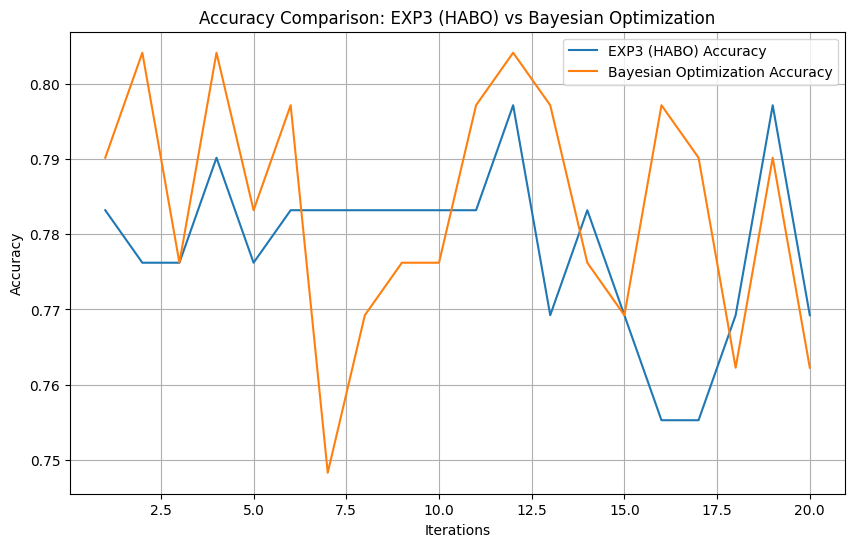

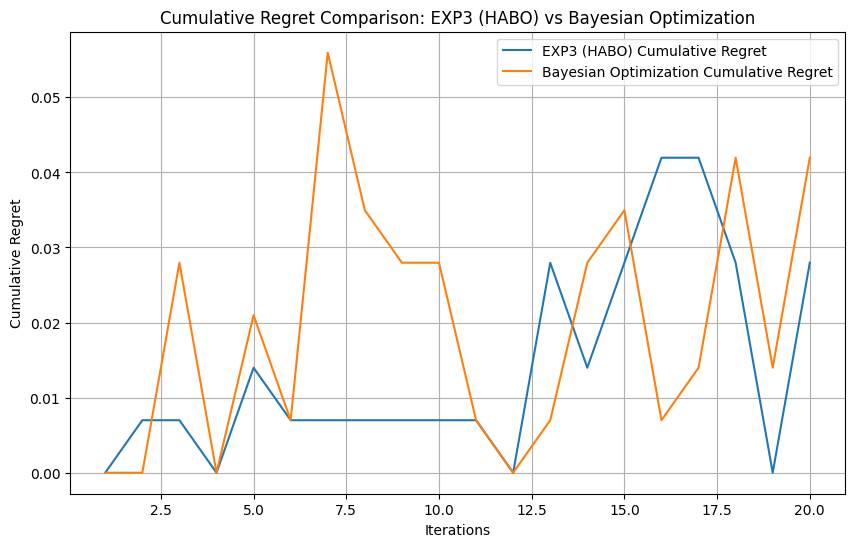

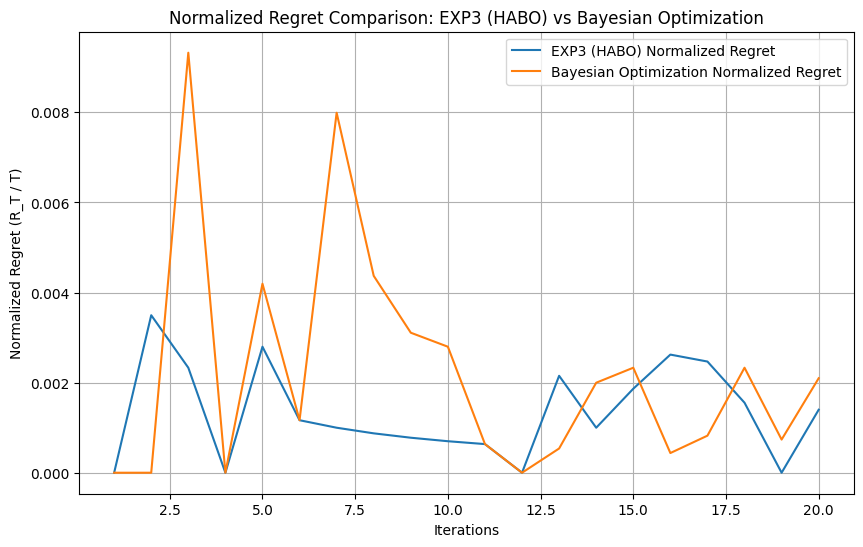

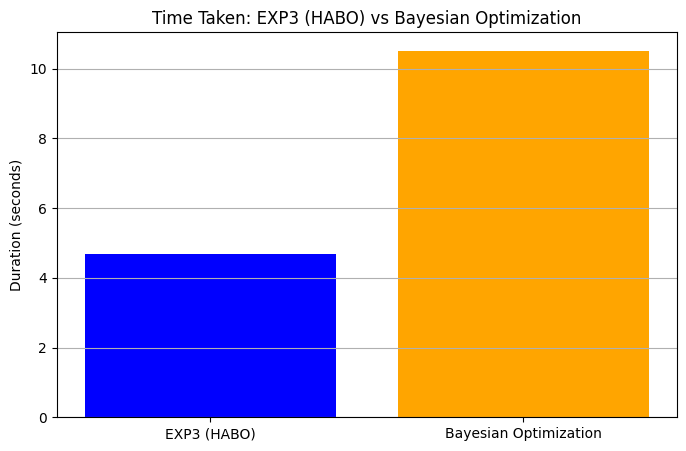

In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

from time import time

from skopt import gp_minimize

from skopt.space import Integer, Categorical

from skopt.utils import use_named_args



# Define the EXP3 algorithm class

class EXP3:

    def __init__(self, n_arms, gamma=0.1):

        self.n_arms = n_arms

        self.gamma = gamma

        self.weights = np.ones(n_arms)

    

    def select_arm(self):

        total_weight = np.sum(self.weights)

        probabilities = (

            (1 - self.gamma) * (self.weights / total_weight) +

            (self.gamma / self.n_arms)

        )

        arm = np.random.choice(self.n_arms, p=probabilities)

        return arm, probabilities

    

    def update(self, chosen_arm, reward, probabilities):

        x = reward / probabilities[chosen_arm]

        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)





# Load the Titanic dataset and preprocess

data = pd.read_csv('train.csv')

data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

data = data.dropna()



label_encoders = {}

for column in ['Sex', 'Embarked']:

    le = LabelEncoder()

    data[column] = le.fit_transform(data[column])

    label_encoders[column] = le



X = data.drop('Survived', axis=1)

y = data['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(

    X, y, test_size=0.2, random_state=42

)



# EXP3 setup

hyperparameter_values = {

    'n_estimators': list(range(50, 301, 5)),

    'max_depth': [None] + list(range(5, 100, 5)),

    'min_samples_split': list(range(2, 50, 2)),

    'max_features': ['sqrt', 'log2', None]

}



current_params = {

    'n_estimators': 50,

    'max_depth': None,

    'min_samples_split': 2,

    'max_features': 'sqrt'

}



bandits = {hp: {'algorithm': EXP3(len(hyperparameter_values[hp]))} for hp in hyperparameter_values}

hyperparameters = list(hyperparameter_values.keys())

hyperparameter_bandit = EXP3(len(hyperparameters))



best_possible_reward = 0

best_accuracy_exp3 = 0

cumulative_regret_exp3 = []

accuracy_exp3 = []

exp3_start = time()



# EXP3 hyperparameter tuning loop

for i in range(20):

    hp_arm_index, hp_probabilities = hyperparameter_bandit.select_arm()

    hp_to_adjust = hyperparameters[hp_arm_index]

    algorithm = bandits[hp_to_adjust]['algorithm']

    arm_index, probabilities = algorithm.select_arm()

    hp_value = hyperparameter_values[hp_to_adjust][arm_index]

    

    previous_value = current_params[hp_to_adjust]

    current_params[hp_to_adjust] = hp_value



    model = RandomForestClassifier(

        n_estimators=current_params['n_estimators'],

        max_depth=current_params['max_depth'],

        min_samples_split=current_params['min_samples_split'],

        max_features=current_params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    reward = accuracy



    algorithm.update(arm_index, reward, probabilities)

    hyperparameter_bandit.update(hp_arm_index, reward, hp_probabilities)



    best_possible_reward = max(best_possible_reward, reward)

    cumulative_regret_exp3.append(best_possible_reward - reward)

    accuracy_exp3.append(accuracy)

    if accuracy > best_accuracy_exp3:

        best_accuracy_exp3 = accuracy

        best_params_exp3 = current_params.copy()



exp3_end = time()

exp3_duration = exp3_end - exp3_start



# Bayesian Optimization setup

space = [

    Integer(50, 300, name='n_estimators'),

    Integer(5, 100, name='max_depth'),

    Integer(2, 50, name='min_samples_split'),

    Categorical(['sqrt', 'log2', None], name='max_features')

]



@use_named_args(space)

def objective(**params):

    model = RandomForestClassifier(

        n_estimators=params['n_estimators'],

        max_depth=params['max_depth'],

        min_samples_split=params['min_samples_split'],

        max_features=params['max_features'],

        random_state=42

    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    return -accuracy



bayesian_start = time()

result = gp_minimize(objective, space, n_calls=20, random_state=42)

bayesian_end = time()

bayesian_duration = bayesian_end - bayesian_start



best_params_bo = {

    'n_estimators': result.x[0],

    'max_depth': result.x[1],

    'min_samples_split': result.x[2],

    'max_features': result.x[3]

}



final_model_bo = RandomForestClassifier(

    n_estimators=best_params_bo['n_estimators'],

    max_depth=best_params_bo['max_depth'],

    min_samples_split=best_params_bo['min_samples_split'],

    max_features=best_params_bo['max_features'],

    random_state=42

)

final_model_bo.fit(X_train, y_train)

final_y_pred_bo = final_model_bo.predict(X_valid)

final_accuracy_bo = accuracy_score(y_valid, final_y_pred_bo)



cumulative_regret_bo = []

accuracy_bo = []

best_possible_reward_bo = 0

for i, func_val in enumerate(result.func_vals):

    reward = -func_val

    best_possible_reward_bo = max(best_possible_reward_bo, reward)

    cumulative_regret_bo.append(best_possible_reward_bo - reward)

    accuracy_bo.append(reward)



# Plot accuracy comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), accuracy_exp3, label="EXP3 (HABO) Accuracy")

plt.plot(range(1, 21), accuracy_bo, label="Bayesian Optimization Accuracy")

plt.xlabel("Iterations")

plt.ylabel("Accuracy")

plt.title("Accuracy Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot cumulative regret comparison

plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), cumulative_regret_exp3, label="EXP3 (HABO) Cumulative Regret")

plt.plot(range(1, 21), cumulative_regret_bo, label="Bayesian Optimization Cumulative Regret")

plt.xlabel("Iterations")

plt.ylabel("Cumulative Regret")

plt.title("Cumulative Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Plot normalized regret comparison

normalized_regret_exp3 = [reg / t for reg, t in zip(cumulative_regret_exp3, range(1, 21))]

normalized_regret_bo = [reg / t for reg, t in zip(cumulative_regret_bo, range(1, 21))]



plt.figure(figsize=(10, 6))

plt.plot(range(1, 21), normalized_regret_exp3, label="EXP3 (HABO) Normalized Regret")

plt.plot(range(1, 21), normalized_regret_bo, label="Bayesian Optimization Normalized Regret")

plt.xlabel("Iterations")

plt.ylabel("Normalized Regret (R_T / T)")

plt.title("Normalized Regret Comparison: EXP3 (HABO) vs Bayesian Optimization")

plt.legend()

plt.grid()

plt.show()



# Time comparison bar chart

plt.figure(figsize=(8, 5))

plt.bar(["EXP3 (HABO)", "Bayesian Optimization"], [exp3_duration, bayesian_duration], color=['blue', 'orange'])

plt.ylabel("Duration (seconds)")

plt.title("Time Taken: EXP3 (HABO) vs Bayesian Optimization")

plt.grid(axis='y')

plt.show()

Initial Model Accuracy: 0.7762
EXP3 Tuning Time: 9.93 seconds
Best Accuracy via EXP3: 0.8112
Bayesian Optimization Time: 11.63 seconds
Best Accuracy via Bayesian Optimization: 0.8042


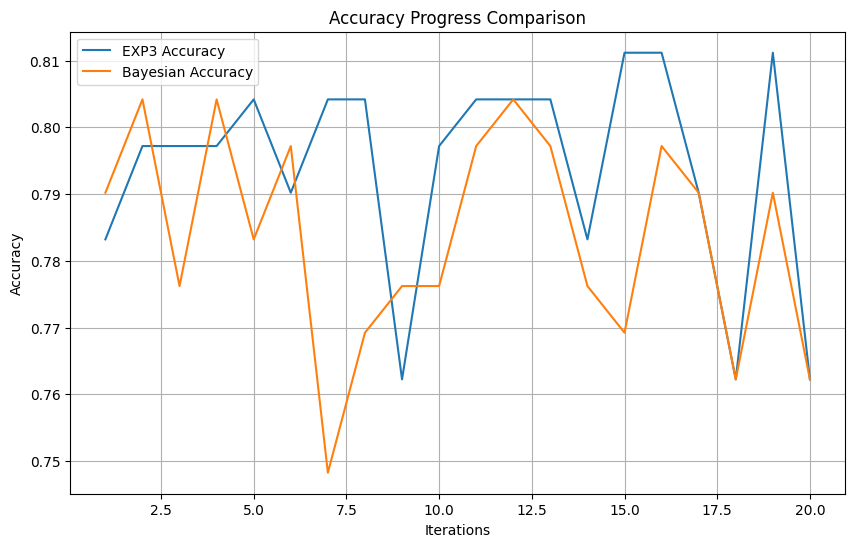

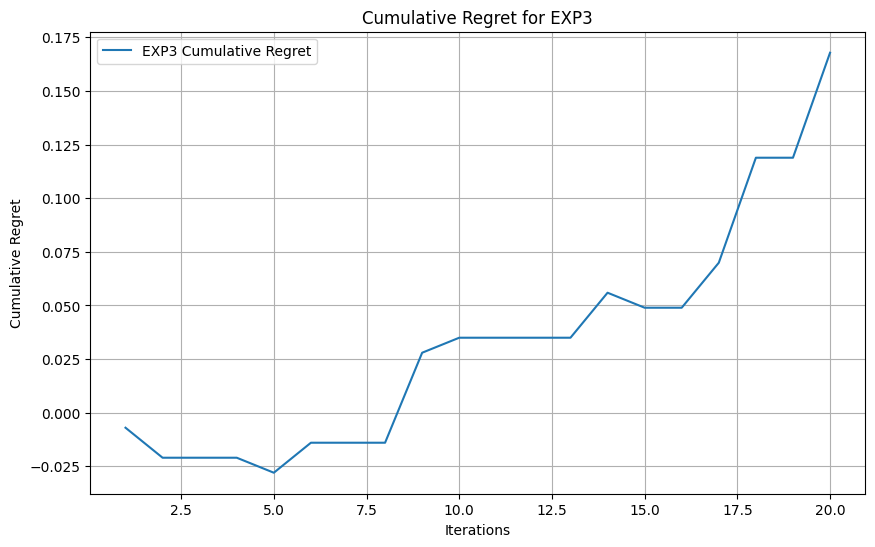

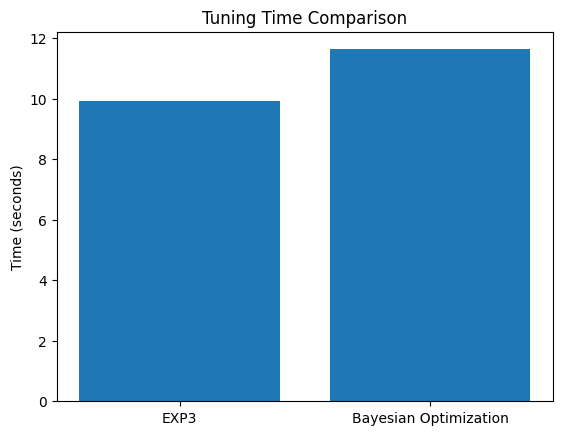

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skopt import gp_minimize
from skopt.space import Integer, Categorical
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
import time

# Load the Titanic dataset
data = pd.read_csv('train.csv')

# Preprocessing steps
# Drop unnecessary columns
data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

# Drop rows with missing values
data = data.dropna()

# Encode categorical variables
label_encoders = {}
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split the data into features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define initial hyperparameters for fairness
initial_hyperparams = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'max_features': 'sqrt'
}

# Train and evaluate the initial model
initial_model = RandomForestClassifier(
    n_estimators=initial_hyperparams['n_estimators'],
    max_depth=initial_hyperparams['max_depth'],
    min_samples_split=initial_hyperparams['min_samples_split'],
    max_features=initial_hyperparams['max_features'],
    random_state=42
)
initial_model.fit(X_train, y_train)
initial_accuracy = accuracy_score(y_valid, initial_model.predict(X_valid))
print(f"Initial Model Accuracy: {initial_accuracy:.4f}")

### EXP3 Algorithm
class EXP3:
    def __init__(self, n_arms, gamma=0.1):
        self.n_arms = n_arms
        self.gamma = gamma
        self.weights = np.ones(n_arms)
    
    def select_arm(self):
        total_weight = np.sum(self.weights)
        probabilities = (
            (1 - self.gamma) * (self.weights / total_weight) +
            (self.gamma / self.n_arms)
        )
        arm = np.random.choice(self.n_arms, p=probabilities)
        return arm, probabilities
    
    def update(self, chosen_arm, reward, probabilities):
        x = reward / probabilities[chosen_arm]
        self.weights[chosen_arm] *= np.exp((self.gamma * x) / self.n_arms)

# EXP3 Tuning
exp3_params = initial_hyperparams.copy()
hyperparameter_values = {
    'n_estimators': list(range(50, 301, 10)),
    'max_depth': [None] + list(range(5, 101, 10)),
    'min_samples_split': list(range(2, 51, 2)),
    'max_features': ['sqrt', 'log2', None]
}
n_iterations = 20

# Initialize the EXP3 bandits
exp3_bandits = {hp: EXP3(len(values)) for hp, values in hyperparameter_values.items()}
best_accuracy_exp3 = initial_accuracy
exp3_accuracy_progress = []
cumulative_regret_exp3 = []

exp3_start_time = time.time()

for iteration in range(n_iterations):
    # Select a hyperparameter to tune
    selected_hp = np.random.choice(list(hyperparameter_values.keys()))
    bandit = exp3_bandits[selected_hp]
    
    # Select a value for the chosen hyperparameter
    arm, probabilities = bandit.select_arm()
    chosen_value = hyperparameter_values[selected_hp][arm]
    
    # Update the parameter
    old_value = exp3_params[selected_hp]
    exp3_params[selected_hp] = chosen_value

    # Train the model with the updated parameters
    model = RandomForestClassifier(
        n_estimators=exp3_params['n_estimators'],
        max_depth=exp3_params['max_depth'],
        min_samples_split=exp3_params['min_samples_split'],
        max_features=exp3_params['max_features'],
        random_state=42
    )
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_valid, model.predict(X_valid))
    exp3_accuracy_progress.append(accuracy)

    # Update bandit
    reward = accuracy
    bandit.update(arm, reward, probabilities)
    
    # Calculate regret
    regret = best_accuracy_exp3 - accuracy
    cumulative_regret_exp3.append(cumulative_regret_exp3[-1] + regret if cumulative_regret_exp3 else regret)
    
    # Update best accuracy if applicable
    if accuracy > best_accuracy_exp3:
        best_accuracy_exp3 = accuracy
    else:
        exp3_params[selected_hp] = old_value  # Revert if not better

exp3_time = time.time() - exp3_start_time
print(f"EXP3 Tuning Time: {exp3_time:.2f} seconds")
print(f"Best Accuracy via EXP3: {best_accuracy_exp3:.4f}")

### Bayesian Optimization
space = [
    Integer(50, 300, name='n_estimators'),
    Integer(5, 100, name='max_depth'),
    Integer(2, 50, name='min_samples_split'),
    Categorical(['sqrt', 'log2', None], name='max_features')
]

@use_named_args(space)
def objective(**params):
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        max_features=params['max_features'],
        random_state=42
    )
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_valid, model.predict(X_valid))
    return -accuracy

bayes_start_time = time.time()
result = gp_minimize(objective, space, n_calls=n_iterations, random_state=42)
bayes_time = time.time() - bayes_start_time

best_accuracy_bayes = -result.fun
print(f"Bayesian Optimization Time: {bayes_time:.2f} seconds")
print(f"Best Accuracy via Bayesian Optimization: {best_accuracy_bayes:.4f}")

### Comparative Plots
# Accuracy Progress
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), exp3_accuracy_progress, label="EXP3 Accuracy")
plt.plot(range(1, n_iterations + 1), -np.array(result.func_vals), label="Bayesian Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy Progress Comparison")
plt.legend()
plt.grid()
plt.show()

# Cumulative Regret
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), cumulative_regret_exp3, label="EXP3 Cumulative Regret")
plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret for EXP3")
plt.legend()
plt.grid()
plt.show()

# Time Comparison
plt.bar(["EXP3", "Bayesian Optimization"], [exp3_time, bayes_time])
plt.title("Tuning Time Comparison")
plt.ylabel("Time (seconds)")
plt.show()